In [1]:
%matplotlib inline
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from scipy import optimize
import optunity

# Search space

In [2]:
# range of possible lengths
L = np.linspace(0.01,3,200)

# physical angles for each length
theta_max = np.rad2deg(np.arctan(0.8/L))
theta_min = np.rad2deg(np.arctan(0.1/L))

In [3]:
def theta(beta, M1, gamma):
    # function of the compressible flow theta-beta-Mach function to get theta
    # constraints of the function to avoid angles outside range
    if np.rad2deg(beta) < 0:
        return 10
    elif np.rad2deg(beta) > 90:
        return 10
    else:
        # negative sign is used to minime the function
        return -np.arctan(2*(M1**2*(np.sin(beta))**2-1)/((np.tan(beta))*(M1**2*(gamma+np.cos(2*beta))+2)))

In [4]:
# case boundary conditions
M1 = 2
gamma = 1.4

In [5]:
# minimum possible angle for detached oblique shock waves
minimum = optimize.fmin(theta, np.deg2rad(20), args=(M1, gamma))
detached = -np.rad2deg(theta(minimum[0],M1,gamma))
print('Detached oblique shock waves will occur if theta > %.4f deg' %detached)

Optimization terminated successfully.
         Current function value: -0.400964
         Iterations: 18
         Function evaluations: 36
Detached oblique shock waves will occur if theta > 22.9735 deg


In [6]:
def Lmin(x):
    # difference between detached shock wave angle and the minimum geometrical angle for each x
    # created to compute the length where maximum physical angle mets minimum geometrical angle
    if x > 0.1:
        return np.abs(detached - np.rad2deg(np.arctan(0.1/x)))
    else:
        return np.inf

In [7]:
minimum_L = optimize.fmin(Lmin, 0.25)
print('The length where minimum geometrical theta angle intersects maximum physical angle is %.4f' %minimum_L)

Optimization terminated successfully.
         Current function value: 0.004217
         Iterations: 9
         Function evaluations: 18
The length where minimum geometrical theta angle intersects maximum physical angle is 0.2358


Text(0.5,1,'Search space')

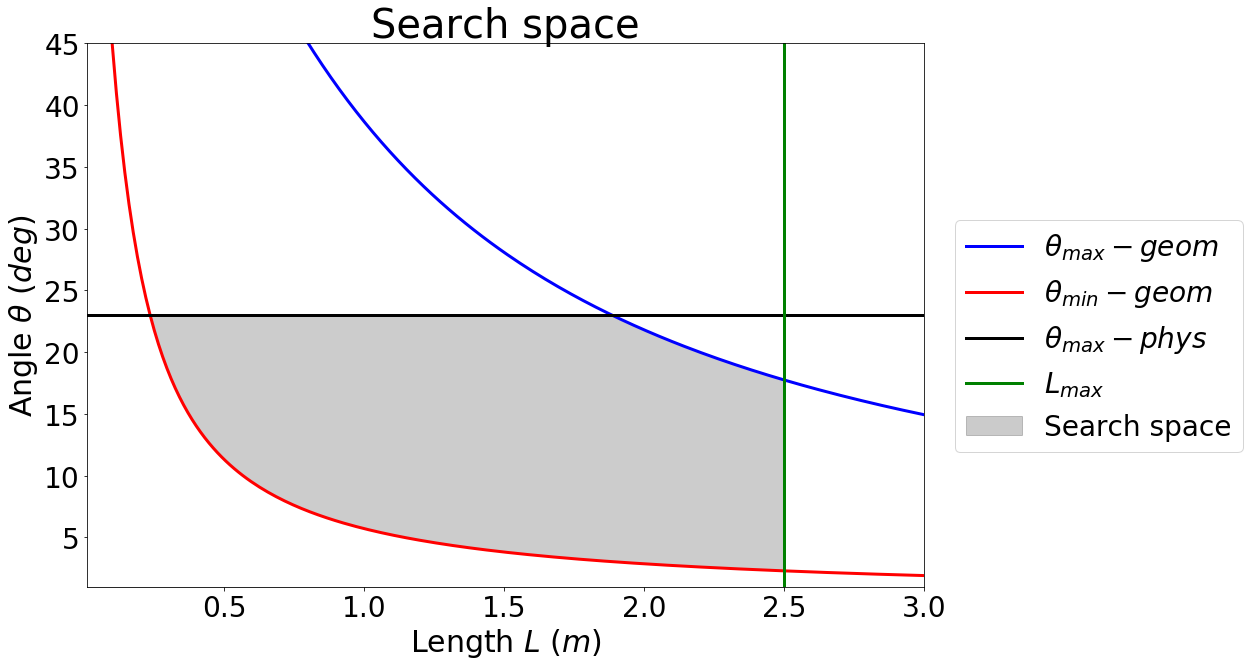

In [8]:
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(L,theta_max,'b',linewidth=3,label=r'$\theta_{max} - geom$')
ax.plot(L,theta_min,'r',linewidth=3,label=r'$\theta_{min} - geom$')
ax.plot([0,3.0],[detached,detached],'k',linewidth=3,label=r'$\theta_{max} - phys$')
ax.plot([2.5,2.5],[0,45],'g',linewidth=3,label=r'$L_{max}$')
ax.set_xlim([L.min(),L.max()])
ax.set_ylim([1,45])
ax.fill_between(L,detached*np.ones(len(L)),color='k',alpha=0.2, label='Search space')
ax.fill_between(L,100*np.ones(len(L)),theta_max,color='w')
ax.fill_between(L,theta_min,color='w')
ax.fill_between([2.5,3.0],[45,45],color='w')
ax.set_xlabel('Length $L$ ($m$)',fontsize=30)
ax.set_ylabel(r'Angle $\theta$ ($deg$)',fontsize=30)
ax.legend(fontsize=28, loc='best', bbox_to_anchor=(1.02,0.7))
ax.tick_params(axis = 'both', labelsize = 28)
ax.set_title('Search space', fontsize = 40)
# plt.savefig('./SearchSpace.png', bbox_inches='tight')

# First population definition

In [9]:
def constraint(L,theta):
    ''' Function to test the length and angle constraints
    INPUTS:
    L:       array with possible lengths
    theta:   array with possible angles theta
    
    OUTPUTS:
    boolMat: boolean matrix with 1 for the non valid points (constrained)'''
    # space preallocation for boolean matrix
    boolMat = np.zeros([len(L)])
    # fill the boolean matrix 
    for i in range(len(L)):
        # maximum allowable length
        if L[i] > 2.5:
            boolMat[i] = True
        # angle for detached shock wave
        elif theta[i] > detached:
            boolMat[i] = True
        # upper geometrical angle limit
        elif L[i]*np.tan(np.deg2rad(theta[i])) > 0.8:
            boolMat[i] = True
        # lower geometrical angle limit
        elif L[i]*np.tan(np.deg2rad(theta[i])) < 0.1:
            boolMat[i] = True
        else:
            boolMat[i] = False
    return boolMat

In [10]:
# get the limits of the x and y components of each individual
x_low = L[np.argwhere(theta_min < detached)[0][0]]
x_high = 2.5
y_low = theta_min[np.argwhere(L > 2.5)[0][0]]
y_high = detached

In [11]:
# Sobol sampling initialization
x1, x2 = zip(*optunity.solvers.Sobol.i4_sobol_generate(2, 128, int(np.sqrt(128))))
sobol = np.vstack(((x_high - x_low) * np.array([x1]) + x_low,
                   (y_high - y_low) * np.array([x2]) + y_low)).T

In [12]:
# unconstraint the Sobol initialization
while sum(constraint(sobol[:,0], sobol[:,1])) != 0:
    boolMat = constraint(sobol[:,0], sobol[:,1])
    for i in np.argwhere(boolMat == True):
        sobol[i] = np.array([x_low+np.random.rand(1)*(x_high-x_low),y_low+np.random.rand(1)*(y_high-y_low)]).T

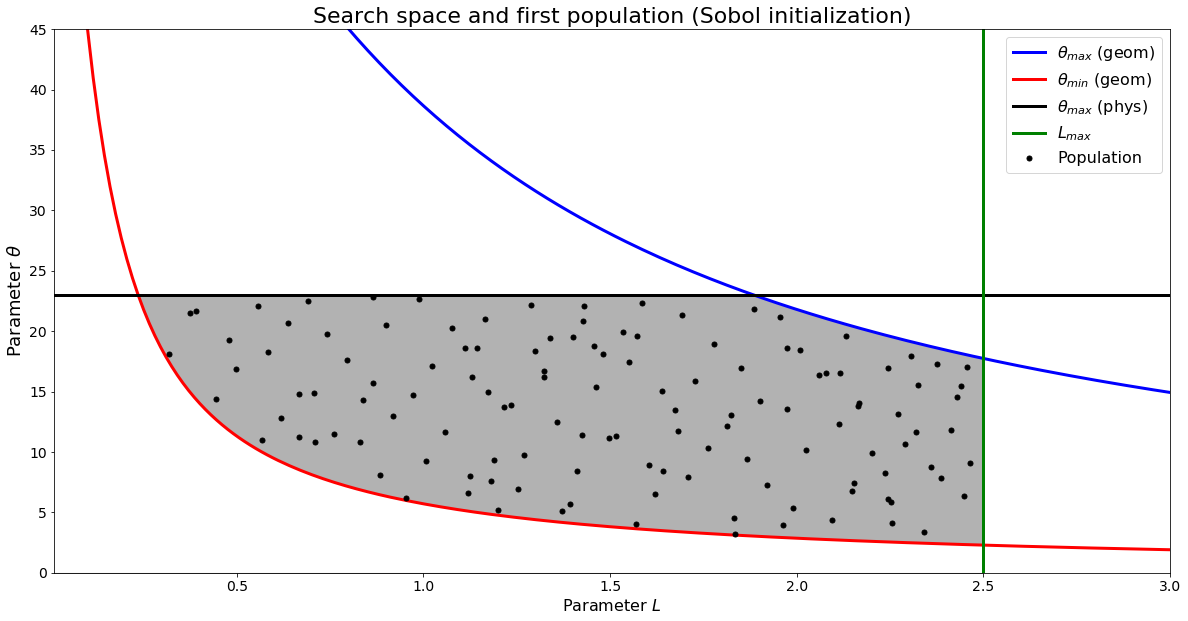

In [13]:
fig, ax = plt.subplots(1, figsize=(20,10))
ax.plot(L,theta_max,'b',linewidth=3,label=r'$\theta_{max}$ (geom)')
ax.plot(L,theta_min,'r',linewidth=3,label=r'$\theta_{min}$ (geom)')
ax.plot([0,3.0],[detached,detached],'k',linewidth=3,label=r'$\theta_{max}$ (phys)')
ax.plot([2.5,2.5],[0,45],'g',linewidth=3,label=r'$L_{max}$')
ax.set_xlim([L.min(),L.max()])
ax.set_ylim([0,45])
ax.fill_between(L,detached*np.ones(len(L)),color='k',alpha=0.3)
ax.fill_between(L,100*np.ones(len(L)),theta_max,color='w')
ax.fill_between(L,theta_min,color='w')
ax.fill_between([2.5,3.0],[45,45],color='w')
ax.set_xlabel('Parameter $L$',fontsize=16)
ax.set_ylabel(r'Parameter $\theta$',fontsize=18)
ax.tick_params(axis = 'both', labelsize = 14)
ax.set_title('Search space and first population (Sobol initialization)', fontsize = 22)
ax.plot(sobol[:,0],sobol[:,1],'k.',markersize=10,label='Population')
ax.legend(fontsize=16, loc='best')